# TreeRBM usage example

Import dependences

In [1]:
import sys
import os
home = '/'.join(os.getcwd().split('/')[:-1])

In [2]:
os.chdir(home)
sys.path.append(home + '/src')
sys.path.append(home + '/data')
sys.path.append(home + '/src/RBMs')
import importlib
RBM = importlib.import_module('PottsBernoulliRBM').RBM
import treeRBM
import torch
import numpy as np
import h5py
import matplotlib.pyplot as plt
from torch.nn.functional import one_hot
import json
from tqdm import tqdm

device = torch.device('cuda:1')

# use LaTeX fonts in the plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Load the model

In [3]:
fname_data = 'data/MNIST.h5'
fname_model = 'models/MNIST/PottsBernoulliRBM-2023.2.7.15.27-MNIST-ep10000-lr0.001-Nh512-NGibbs100-mbs500-PCD.h5'

Visualize the weight matrix eigenvalues as a function of the training time

In [4]:
f_model = h5py.File(fname_model, 'r')
alltime = np.sort(f_model['alltime'])
alls_W = []
allt = []
pbar = tqdm(total=len(alltime), colour='red')
for t in alltime:
    ep = int(t) # epoch to which retrieve the RBM
    W = torch.tensor(f_model['W' + str(ep)][()])
    W = W.reshape(W.shape[0] * W.shape[1], W.shape[2])
    s_W = torch.linalg.svdvals(W) 
    alls_W.append(s_W.unsqueeze(-1))
    allt.append(ep)
    pbar.update(1)
allt = np.array(allt)
alls_W = torch.cat(tuple(alls_W), dim=1)
f_model.close()

 95%|█████████▌| 95/100 [00:01<00:00, 61.80it/s]

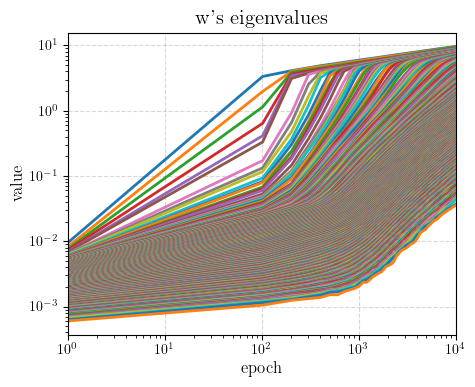

In [5]:
fig, ax = plt.subplots(dpi=100, nrows=1, ncols=1, figsize=(5, 4))

lim1 = 1
lim2 = allt[-1]

ax.set_title('w\'s eigenvalues', size=15)
ax.set_xlabel('epoch', size=12)
ax.set_ylabel('value', size=12)
ax.set_xlim(lim1, lim2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.5, ls='dashed')
ax.plot(np.array(allt), alls_W.t(), lw=2);

In [6]:
data_type = 'test'
n_data = 2000 # take only part of the dataset. Large sequences would otherwise fill the GPU's memory

f_data = h5py.File(fname_data, 'r')
f_model = h5py.File(fname_model, 'r')
all_X_data = np.array(f_data[data_type])
all_labels_data = f_data[data_type + '_labels'].asstr()[()]

X_data = torch.tensor(all_X_data[:n_data], device=device, dtype=torch.float32)
labels_data = all_labels_data[:n_data].astype(np.int32)

rbm = RBM(device=device)
alltime = f_model['alltime'][()]
print('All times:\n', alltime)
stamp = input('Select the time stamp: ')
rbm.loadRBM(fname_model, stamp=int(stamp))
stamp = rbm.t_age

All times:
 [    1   102   203   304   405   506   607   708   809   910  1011  1112
  1213  1314  1415  1516  1617  1718  1819  1920  2021  2122  2223  2324
  2425  2526  2627  2728  2829  2930  3031  3132  3233  3334  3435  3536
  3637  3738  3839  3940  4041  4142  4243  4344  4445  4546  4647  4748
  4849  4950  5051  5152  5253  5354  5455  5556  5657  5758  5859  5960
  6061  6162  6263  6364  6465  6566  6667  6768  6869  6970  7071  7172
  7273  7374  7475  7576  7677  7778  7879  7980  8081  8182  8283  8384
  8485  8586  8687  8788  8889  8990  9091  9192  9293  9394  9495  9596
  9697  9798  9899 10000]


## Visualize data and TAP fixed points

In [7]:
X_data_onehot = one_hot(X_data.type(torch.int64)).type(torch.float32).reshape(n_data, -1)
U, S, Vt = torch.linalg.svd(X_data_onehot.cpu() - X_data_onehot.mean(0).cpu())
h_data, mh_data = rbm.sampleHiddens(X_data.type(torch.int64))
Uh, Sh, Vth = torch.linalg.svd(h_data.cpu() - h_data.cpu().mean(0))

Xproj_data = X_data_onehot.cpu() @ Vt.mT
hproj_data = h_data.cpu() @ Vth.mT

In [8]:
print('\nSampling order 2:')
X_tap, h_tap = rbm.iterate_mean_field(X_data.type(torch.int64), order=2, batch_size=250, alpha=1e-4)
X_tap = X_tap.reshape(n_data, -1)
Xproj_tap = X_tap.cpu() @ Vt.mT
hproj_tap = h_tap.cpu() @ Vth.mT


Sampling order 2:


Iterating Mean Field: 100%|██████████| 8/8 [00:20<00:00,  2.60s/it]


In [9]:
# generate data
rand_init = torch.randint(0, 2, (100, X_data.shape[1]), dtype=torch.int64, device=device)
X_gen, _, h_gen, _ = rbm.sampling(rand_init, it_mcmc=10000)
X_gen_onehot = one_hot(X_gen.type(torch.int64)).type(torch.float32).reshape(100, -1)
Xproj_gen = X_gen_onehot.cpu() @ Vt.mT
hproj_gen = h_gen.cpu() @ Vth.mT

MCMC steps: 100%|██████████| 10000/10000 [00:11<00:00, 851.28it/s]


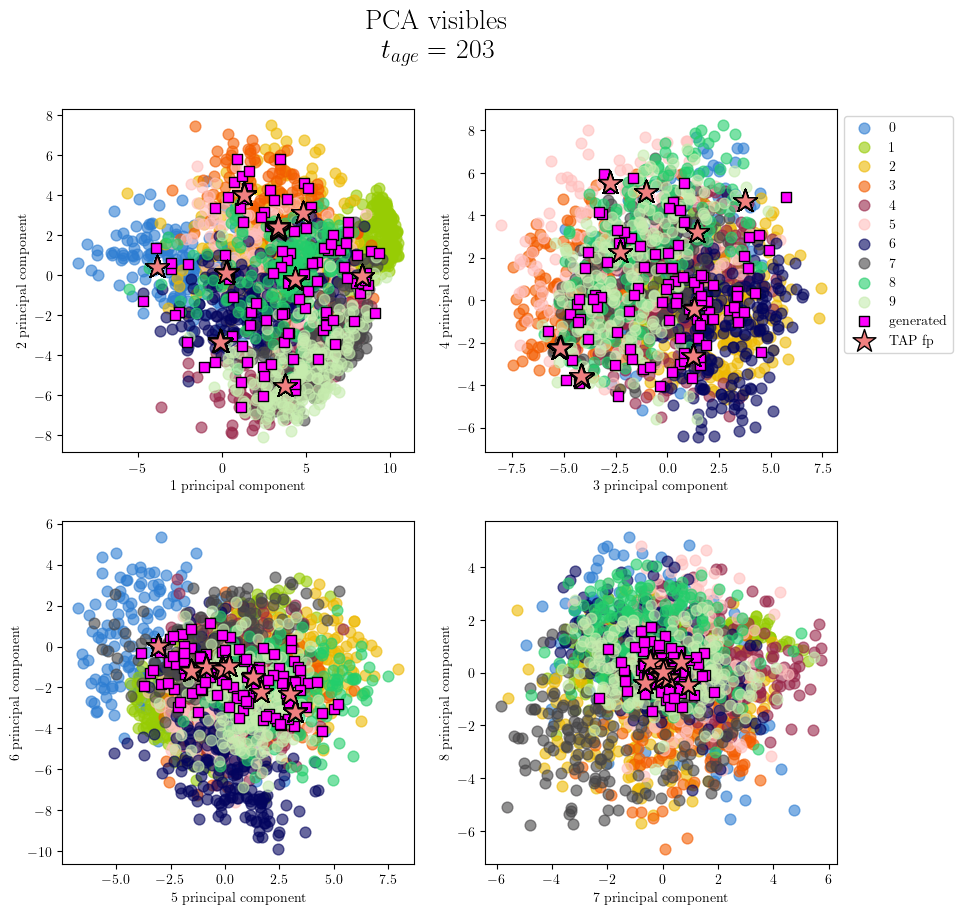

In [10]:
fig = plt.figure(dpi=100, figsize=(10, 10))
fig.suptitle('PCA visibles\n' + r'$t_{age}=$' + ' {0}'.format(stamp), size=20)

colors_list = ['#2d7dd2', '#97cc04', '#eeb902', '#f45d01', '#982649', '#ffc0be', '#03045e', '#474647', '#23ce6b', '#c6ecae']
colmap = {i : col for i, col in enumerate(colors_list)}

def plot_scatter(ax, proj1, proj2):
    for g in np.unique(labels_data):
        idx = np.where(labels_data == g)[0]
        ax.scatter(Xproj_data[idx, proj1].cpu(), Xproj_data[idx, proj2].cpu(), alpha=0.6, s=60, c=colmap[g], zorder=0, label=str(g))
    ax.scatter(Xproj_gen[:, proj1].cpu(), Xproj_gen[:, proj2].cpu(), alpha=1., s=60, c='fuchsia', zorder=1, label='generated', edgecolors='black', marker='s')
    ax.scatter(Xproj_tap[:, proj1], Xproj_tap[:, proj2], alpha=1, s=300, c='lightcoral', marker='*',label='TAP fp', zorder=2, edgecolors='black')
    ax.set_xlabel(f'{proj1+1} principal component')
    ax.set_ylabel(f'{proj2+1} principal component')

ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
plot_scatter(ax1, 0, 1)
plot_scatter(ax2, 2, 3)
plot_scatter(ax3, 4, 5)
plot_scatter(ax4, 6, 7)
ax2.legend(bbox_to_anchor=(1, 1));

## TreeRBM

Import the TreeRBM model

In [11]:
fname_tree = 'trees/TreeRBM-PottsBernoulliRBM-2023.2.7.15.27-MNIST-Gibbs_steps100-train/tree.json'
data_type = 'train'

n_data = 500
f_data = h5py.File(fname_data, 'r')
tree_labels = f_data[data_type + '_labels'].asstr()[()].astype(np.int32).flatten()[:n_data]
X = torch.tensor(np.array(f_data[data_type])[:n_data], device=device)
n_labels = 10
leaves_names = list(map(str, list(range(len(tree_labels)))))

colors_list = ['#2d7dd2', '#97cc04', '#eeb902', '#f45d01', '#982649', '#ffc0be', '#03045e', '#474647', '#23ce6b', '#c6ecae']
colors_dict = {i : colors_list[i] for i in tree_labels}
labels_dict = {leaf_name : leaf_label for leaf_name, leaf_label in zip(leaves_names, tree_labels)}

f_data.close()

tree = treeRBM.TreeRBM(fname_model=fname_model, device=device)
tree.load_tree(fname_tree)

Create the netwick tree and the annoatation files for iTOL

In [12]:
max_depth = 30
t = tree.generate_tree(leaves_names, labels_dict=labels_dict, colors_dict=colors_dict, depth=max_depth)

## Images of the internal nodes

In [13]:
f_gen = h5py.File('trees/TreeRBM-PottsBernoulliRBM-2023.2.7.15.27-MNIST-Gibbs_steps100-train/node_features.h5', 'r')
print(list(f_gen.keys())[:20])

['level0-label0', 'level1-label0', 'level1-label1', 'level10-label0', 'level10-label1', 'level10-label10', 'level10-label11', 'level10-label12', 'level10-label13', 'level10-label14', 'level10-label15', 'level10-label16', 'level10-label17', 'level10-label18', 'level10-label19', 'level10-label2', 'level10-label20', 'level10-label21', 'level10-label22', 'level10-label23']


Each node of the tree is identified by the `level` inside the tree and the `label` that the node has inside its level. The level of the chosen node is given by the number of labels after the root identifiers "R0", and can be visualized, using iTOL, by activating the `internal tree scale` option present in the `Advanced` menu. Instead, the label is determined by the last number present in the node name string.

e.g. the name "R0-0-3-5-5-5-5-5-" identifies a node in the 7th level with label 5. Hence, the corresponding fixed point is saved under the name "level7-label5".

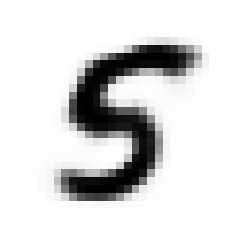

In [14]:
img = f_gen['level10-label4'][()]
plt.imshow(img.reshape(28, 28), cmap='Greys')
plt.axis('off');

In [15]:
f_gen.close()